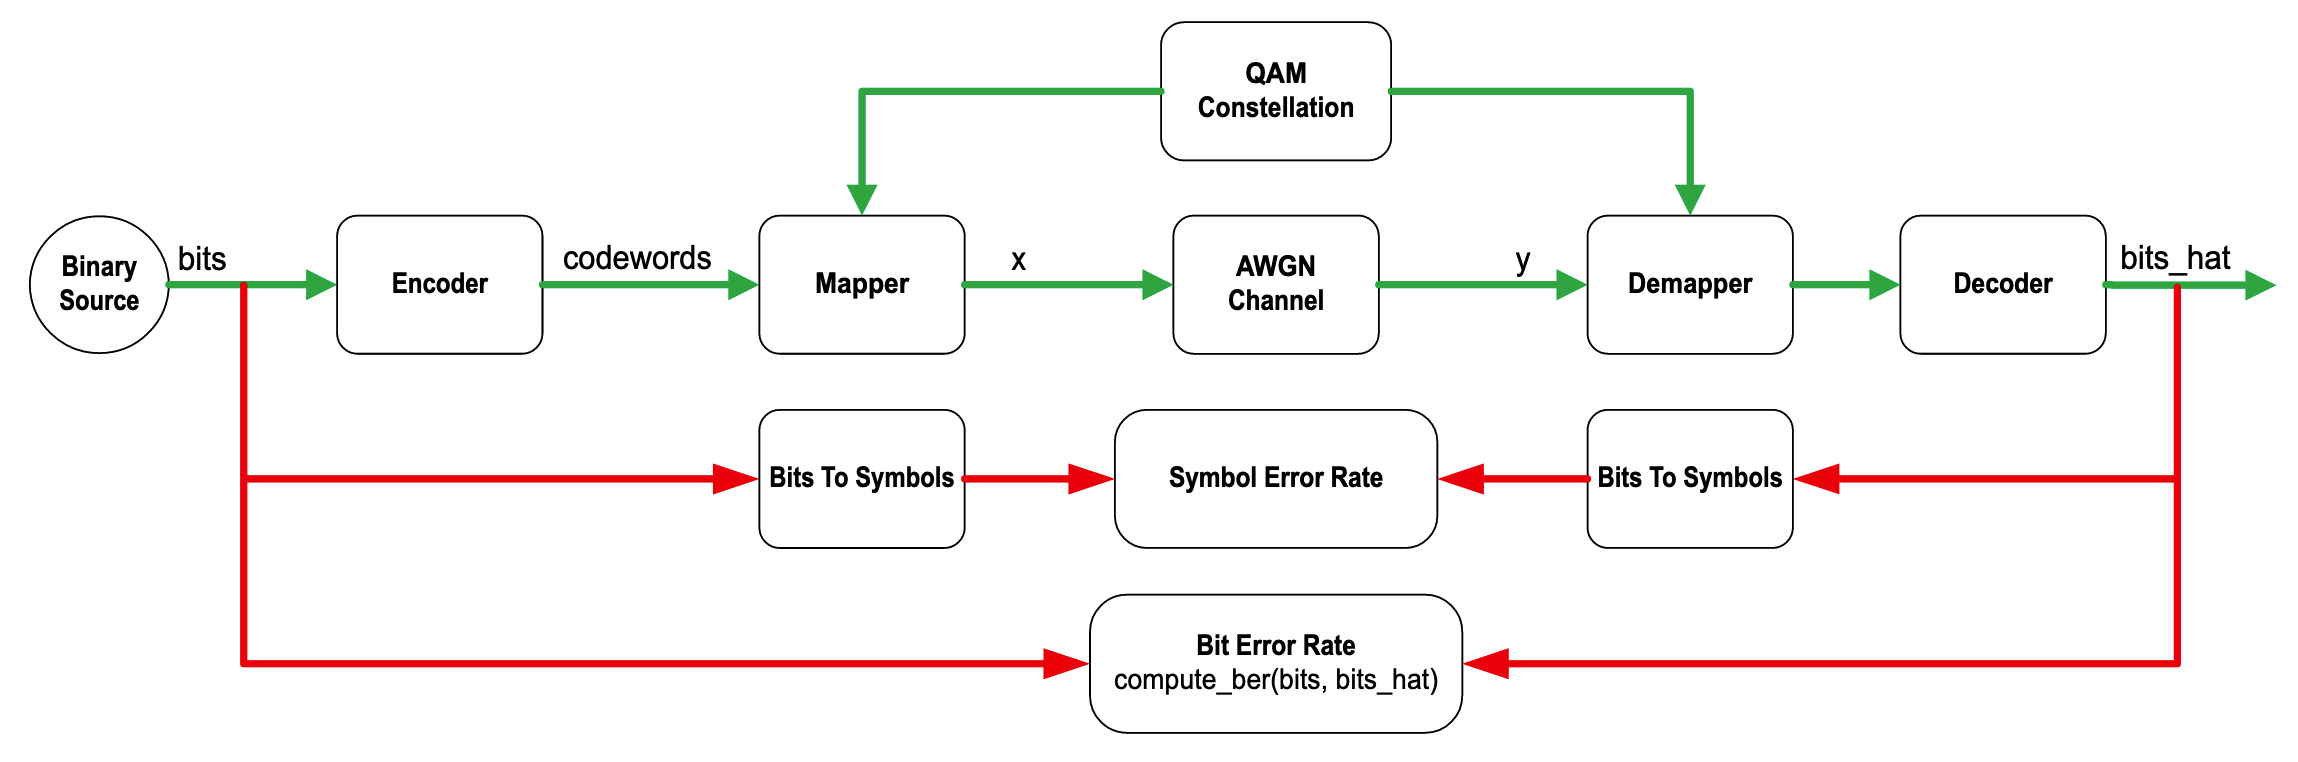

## Wrong

bers_UncodedSystem:
 [0.36129688 0.34499805 0.32218359 0.30050586 0.27742969 0.25255469
 0.22691016 0.20162305 0.1766582  0.15327539 0.12907617 0.10629297
 0.08547656 0.06449805 0.04615625 0.03083594 0.01878906 0.00976758
 0.004375   0.00188867]
bers_CodedSystem:
 [0.42821094 0.41884961 0.40782031 0.3919707  0.37808789 0.36105859
 0.34172266 0.32079687 0.29475391 0.26962109 0.2371875  0.19601953
 0.11762891 0.02002148 0.00076953 0.         0.         0.
 0.         0.        ]
sers_UnodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
sers_CodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


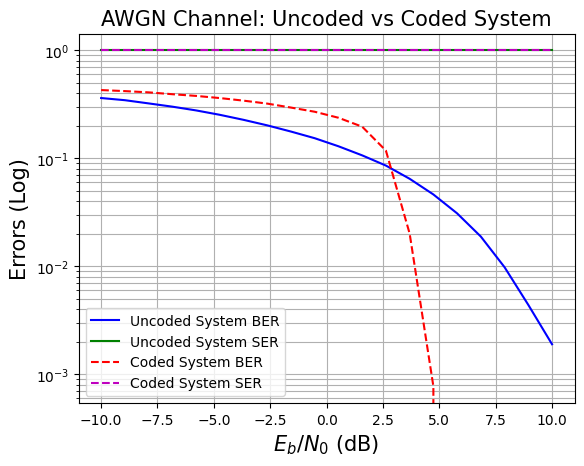

In [96]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    
    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    ser_UncodedSystem = compute_ser(x_UncodedSystem, y_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)
	
    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
	    
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
		
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)
		    
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
			
    ser_CodedSystem = compute_ser(x_CodedSystem, y_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))
title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

## Uncoding: BER vs SER

bers_UncodedSystem:
 [0.3623867  0.34348488 0.32285309 0.30205536 0.27779961 0.25270653
 0.22753143 0.20266342 0.17644501 0.15188026 0.12983704 0.1067028
 0.08426094 0.06415558 0.04606819 0.03041077 0.01884079 0.01004601
 0.0045166  0.00168419]
sers_UnodedSystem:
 [0.836  0.8168 0.7949 0.7707 0.7417 0.7052 0.6657 0.62   0.5647 0.5081
 0.4494 0.3802 0.3079 0.2403 0.1758 0.1178 0.0739 0.0398 0.018  0.0067]


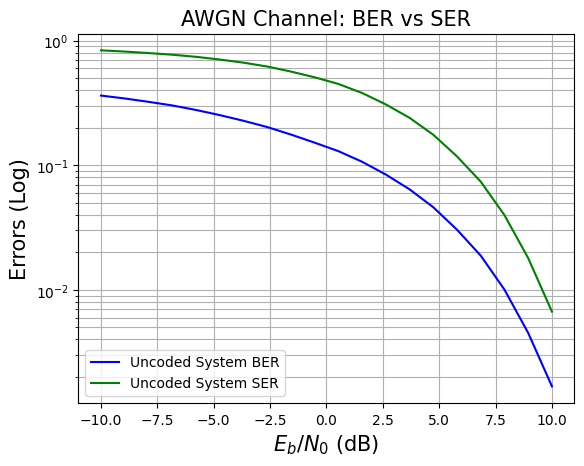

In [106]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2048 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
# bers_CodedSystem = []
# sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    # codewords = LDPC_encoder(bits)

    # x_CodedSystem = mapper(codewords)

    # y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    # llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    # bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    # Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    # ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    # error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # # print('compare =\n',compare)

    # error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # # print('compare_reshape =\n',compare_reshape)

    # num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # # print('num_symbol_errors =\n',num_symbol_errors)

    # ser_UncodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    # bers_CodedSystem += [ber_CodedSystem]
    # sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
# print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
# print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
# plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
# plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

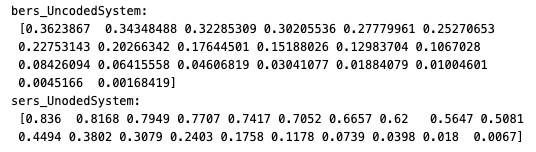
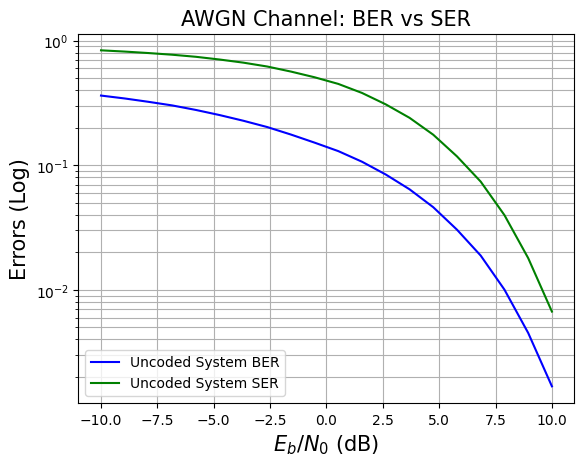

## LDPC Coding: BER vs SER

bers_UncodedSystem:
 [0.36209488 0.34420776 0.32220078 0.30047607 0.27581406 0.25379562
 0.22718048 0.20152664 0.17825699 0.15332794 0.12971497 0.1059494
 0.08404541 0.06355667 0.0461235  0.0297966  0.01854324 0.00998306
 0.00454712 0.00177765]
bers_CodedSystem:
 [4.29172516e-01 4.16996002e-01 4.06818390e-01 3.93390656e-01
 3.79989624e-01 3.61633301e-01 3.42426300e-01 3.20423126e-01
 2.95856476e-01 2.67112732e-01 2.36949921e-01 1.95407867e-01
 1.16443634e-01 2.08358765e-02 1.79290771e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
sers_UnodedSystem:
 [0.8342 0.8186 0.7972 0.7706 0.7381 0.7095 0.6662 0.6191 0.5723 0.5103
 0.4483 0.3771 0.3077 0.2379 0.176  0.1159 0.0726 0.0397 0.0181 0.0071]
sers_CodedSystem:
 [8.917e-01 8.793e-01 8.714e-01 8.604e-01 8.464e-01 8.283e-01 8.054e-01
 7.791e-01 7.484e-01 7.079e-01 6.597e-01 5.844e-01 3.705e-01 6.880e-02
 7.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]


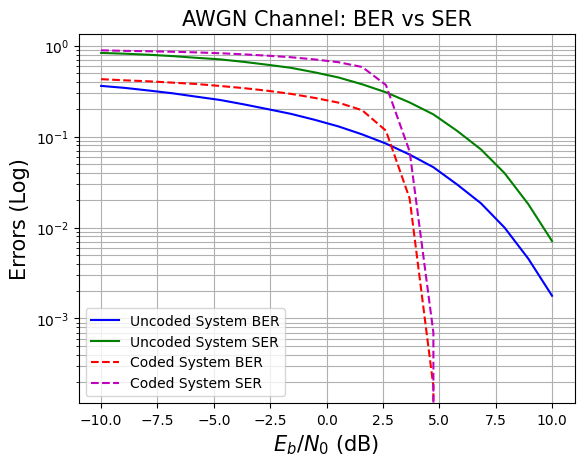

In [108]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)

    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_CodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

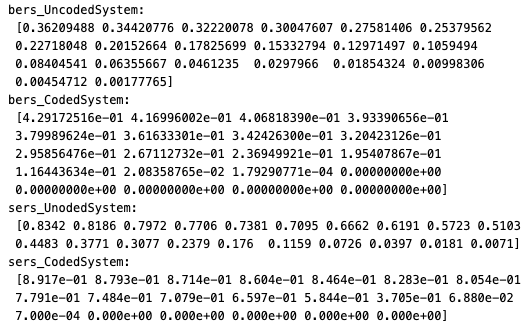
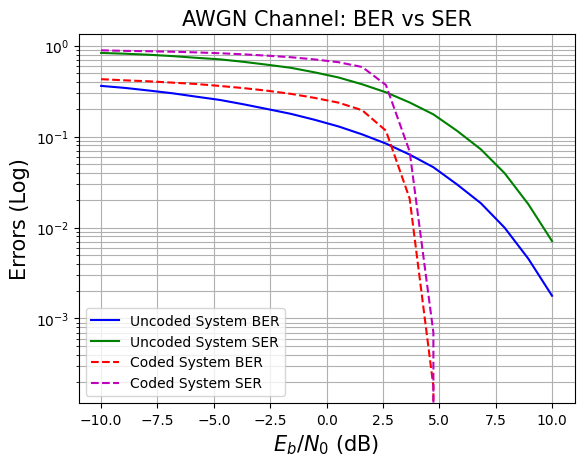

## Linear Coding & LDPC Coding: BER vs SER

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser
from sionna.fec.linear import LinearEncoder, OSDecoder

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# Linear Encoder
Linear_encoder = LinearEncoder(rate=CODERATE, constraint_length=3)

# Linear Decoder
Linear_decoder = OSDecoder(Linear_encoder)

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits.shape =\n',bits.shape)
# print('bits = \n',bits)

Tx_Symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))
# print('Tx_Symbols.shape =\n',Tx_Symbols.shape)
# print('Tx_Symbols = \n',Tx_Symbols)

num_symbols = BATCH_SIZE*(BLOCK_LENGTH/NUM_BITS_PER_SYMBOL)
# print('num_symbols =\n',num_symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    Rx_Symbols_UncodedSystem = np.reshape(bits_hat_UncodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
    # print('Rx_Symbols.shape =\n',Rx_Symbols_UncodedSystem.shape)
    # print('Rx_Symbols = \n',Rx_Symbols_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    error_array_UncodedSystem = np.all(Tx_Symbols == Rx_Symbols_UncodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_UncodedSystem_reshape = np.reshape(error_array_UncodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_UncodedSystem = np.count_nonzero(np.sum(~error_array_UncodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_UncodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_UncodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = LDPC_encoder(bits)

    x_CodedSystem = mapper(codewords)

    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
        
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
        
    bits_hat_CodedSystem = LDPC_decoder(llr_CodedSystem)

    Rx_Symbols_CodedSystem = np.reshape(bits_hat_CodedSystem, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)) # type: ignore
            
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
            
    error_array_CodedSystem = np.all(Tx_Symbols == Rx_Symbols_CodedSystem, axis=2)
    # print('compare =\n',compare)

    error_array_CodedSystem_reshape = np.reshape(error_array_CodedSystem, (BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), 1)) # type: ignore
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors_CodedSystem = np.count_nonzero(np.sum(~error_array_CodedSystem_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser_UncodedSystem = round(num_symbol_errors_CodedSystem/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)
    # ser_CodedSystem = compute_ser(Tx_Symbols, Rx_Symbols_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))

title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()